<a href="https://colab.research.google.com/github/NatalyaEvans/ETNP_stoich/blob/main/pyompa_scripts/ETNP_pyompa_for_WOD_full_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This script first performs an eOMP on the ETNP ODZ data from the WOD18 usung the core endmembers. Next, it generates a range of potential endmember nutrient concentrations, based on remineralization stoichiometry, and performs eOMP on all of them too. These calculations are performed because the nitrate anaerobic slope is sensitive to endmember nutrient concentrations. 

To do:
Comment the shit out of this
Load files in from github instead of drive
Load in sensitivity code from github instead of just pasting it in here


Install pyompa and gsw

In [ ]:
!pip install pyompa==0.4.2.0
!pip install gsw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyompa: filename=pyompa-0.4.2.0-py3-none-any.whl size=27944 sha256=fdf35d31eb55ee652733e9845cc1c938816e0574c9dd92d45d0767a779da1a2d
  Stored in directory: /root/.cache/pip/wheels/ee/bf/52/4e3078948c0fc6eacfffc76536a754087fb12697781430ecec
Successfully built pyompa
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.4 MB 6.1 MB/s 



Load the input data

In [ ]:
import scipy.io
from scipy.io import loadmat
import pandas as pd
import numpy as np
import json
from collections import OrderedDict

!wget https://raw.githubusercontent.com/NatalyaEvans/ETNP_stoich/main/pyompa_scripts/WOD_ETNP_pyompa_2_reduced.csv -O WOD_ETNP_pyompa_2_reduced.csv
!wget https://raw.githubusercontent.com/NatalyaEvans/ETNP_stoich/main/pyompa_scripts/ETNP_pyompa_ref_values.csv -O ETNP_pyompa_ref_values.csv


--2022-11-08 05:22:01--  https://raw.githubusercontent.com/NatalyaEvans/ETNP_stoich/main/pyompa_scripts/WOD_ETNP_pyompa_2_reduced.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 469703 (459K) [text/plain]
Saving to: ‘WOD_ETNP_pyompa_2_reduced.csv’

WOD_ETNP_pyompa_2_r 100%[===================>] 458.69K  --.-KB/s    in 0.03s   

2022-11-08 05:22:01 (16.6 MB/s) - ‘WOD_ETNP_pyompa_2_reduced.csv’ saved [469703/469703]

--2022-11-08 05:22:01--  https://raw.githubusercontent.com/NatalyaEvans/ETNP_stoich/main/pyompa_scripts/ETNP_pyompa_ref_values.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... 

In [ ]:
data_df = pd.read_csv("WOD_ETNP_pyompa_2_reduced.csv")
data_df.head()

Unnamed: 0             Cruise  Station Type yyyy-mm-ddThh:mm:ss.sss  \
0        1320  WOD_UNITED STATES  7550776    B        1994-04-15T23:19   
1        1329  WOD_UNITED STATES  7550776    B        1994-04-15T23:19   
2        1364  WOD_UNITED STATES  7550784    B        1994-04-16T12:12   
3        1374  WOD_UNITED STATES  7550784    B        1994-04-16T12:12   
4        1380  WOD_UNITED STATES  7550792    B        1994-04-17T01:45   

   Longitude [degrees_east]  Latitude [degrees_north]  Bot. Depth [m]  \
0                -110.33330                     3.000          3770.0   
1                -110.33330                     3.000          3770.0   
2                -110.33481                     4.002          3868.0   
3                -110.33481                     4.002          3868.0   
4                -110.33499                     4.995          4219.0   

   NODC Accession Number WOD Cruise Identifier  ...  Neon [nmol/kg]  \
0                    NaN              US013600  ...             NaN   
1                    NaN              US013600  ...             NaN   
2                    NaN              US013600  ...             NaN   
3                    NaN              US013600  ...             NaN   
4                    NaN              US013600  ...             NaN   

  CFC11 [pmol/kg] CFC12 [pmol/kg] CFC113 [pmol/kg]  ~$d~#~^1~^8O [~%]  \
0           0.065           0.036              NaN                NaN   
1           0.065           0.036              NaN                NaN   
2           0.020           0.008              NaN                NaN   
3           0.020           0.008              NaN                NaN   
4           0.324           0.179              NaN                NaN   

   Transmissivity [m~^-~^1]         SA        CT      pdens Nstar  
0                       NaN  34.854243   9.56422  26.785512 -7.17  
1                       NaN  34.854243   9.56422  26.785512 -7.17  
2                       NaN  34.811826   8.37129  26.942846 -7.29  
3                       NaN  34.811826   8.37129  26.942846 -7.29  
4                       NaN  34.900643  11.57128  26.467937 -6.34  

[5 rows x 54 columns]

Define the end-members. Column headers here have to match those of the observations pandas

In [ ]:
endmembers_df_read = pd.read_csv("ETNP_pyompa_ref_values.csv")
endmembers_df_read.head()

Params      CT     SA  Phosphate  Nitrate  Silicate  tCO2  pdens  \
0   13CW  13.410  34.95      2.355    31.20     25.40  2247  26.29   
1  NEPIW   9.470  34.78      2.650    35.60     33.86  2270  26.74   
2   AAIW   5.530  34.70      3.130    43.21     83.68  2323  27.25   
3  uPSUW   7.765  32.96      1.130    10.07     11.40  2235  25.60   

                                               Notes  
0  Adjusted to a more centered point in intersection  
1                                                NaN  
2  Shifted to on the intersection, rather than th...  
3                                                NaN

Remove the non-water types from the endmembers

In [ ]:
endmembers_df = endmembers_df_read.iloc[[0,1,2]] # use uPSUW or no fourth\
display(endmembers_df)

Params     CT     SA  Phosphate  Nitrate  Silicate  tCO2  pdens  \
0   13CW  13.41  34.95      2.355    31.20     25.40  2247  26.29   
1  NEPIW   9.47  34.78      2.650    35.60     33.86  2270  26.74   
2   AAIW   5.53  34.70      3.130    43.21     83.68  2323  27.25   

                                               Notes  
0  Adjusted to a more centered point in intersection  
1                                                NaN  
2  Shifted to on the intersection, rather than th...

Define the pyompa parameters to replicate the matlab OMP analysis, and run the analysis

In [ ]:
import pyompa
from pyompa.endmemberpenaltyfunc import GeneralPenaltyFunc

convertedparamgroups = [
    pyompa.ConvertedParamGroup(
        groupname="aerobic_remin",
        conversion_ratios=[{"Phosphate": 1.0, "Nitrate": 14, "Silicate": 12, "tCO2": 98},
        {"Phosphate": 1.0, "Nitrate": 17, "Silicate": 48, "tCO2": 118}],
        always_positive=False 
        ),pyompa.ConvertedParamGroup(
        groupname="anaerobic_remin",
        conversion_ratios=[
        {"Phosphate": 1.0, "Nitrate": -40, "Silicate": 15, "tCO2": 98},
        {"Phosphate": 1.0, "Nitrate": -65, "Silicate": 48, "tCO2":118}
        ],
        always_positive=True 
        )
]

usage_penalty = { 
    "AAIW": GeneralPenaltyFunc(
        spec={
            'pdens':
            {'type':'exp_other',"alpha":0.03, "beta":50, 'lowerbound':26.7}})}

paramweightings = {
    "CT": 12.0,
    "SA": 8.0,
    "Phosphate": 6.0,
    "Nitrate": 4.0,
    "tCO2": 4.0,
    "Silicate": 2.0
}

settings = {
    "param_names": ["CT", "SA",
                    "Phosphate", "Nitrate",
                    "Silicate"
                    ,"tCO2"
                    ],
    "param_weightings": paramweightings,
    "convertedparam_groups": convertedparamgroups,
    #setting sumtooneconstraint to False replicates the behavior of the
    # MATLAB OMP implementation, which does not enforce mass conservation.
    # By default, sumtooneconstraint is True in pyompa.
    "sumtooneconstraint": True,
    #standardize_by_watertypes=True replicates the normalization behavior
    # of the MATLAB OMP implementation. By default, this is False.
    "standardize_by_watertypes": False}

#Run the analysis, replicating the MATLAB OMP analysis
ETNP_df_ompasoln = pyompa.OMPAProblem(
  obs_df = data_df,
  endmembername_to_usagepenaltyfunc=usage_penalty,
  **settings).solve(
      endmembers_df,
      endmember_name_column="Params")
  
# ** notation uses a python dictionary and maps the keys in that dict to the parameter names, shorthand parameter specs nto a dictionary

Dropping 6 rows that have NA values in the observations
Adding penalty for AAIW
Endmember-idx mapping is
 OrderedDict([('13CW', [0]), ('NEPIW', [1]), ('AAIW', [2])])
params to use: ['CT', 'SA', 'Phosphate', 'Nitrate', 'Silicate', 'tCO2']
param weighting: [12.  8.  6.  4.  2.  4.]
Matrix A:
Trying convertedvariable sign constraint: [1 1 1 1]
On example 0 to 1220 out of 1220
status: optimal
optimal value 109256.34589554994
Original weighted sum squares: 109256.25853495457
Post fix weighted sum squared: 109259.59247580064
Trying convertedvariable sign constraint: [-1 -1  1  1]
On example 0 to 1220 out of 1220
status: optimal
optimal value 152635.59413518777
Original weighted sum squares: 152635.19068825574
Post fix weighted sum squared: 152635.87329949136
On example 0 to 1220 out of 1220
status: optimal
optimal value 19195.12791225299
Original weighted sum squares: 19194.845066353526
Post fix weighted sum squared: 19194.84658064931
objective: 19194.846580649308



Load in plotting tools

In [ ]:
from matplotlib import pyplot as plt
from pyompa import (plot_ompasoln_endmember_fractions,                       
                    plot_ompasoln_residuals,                                 
                    plot_ompasoln_endmember_usagepenalties)

Plot results

Water mass fractions and deltaP


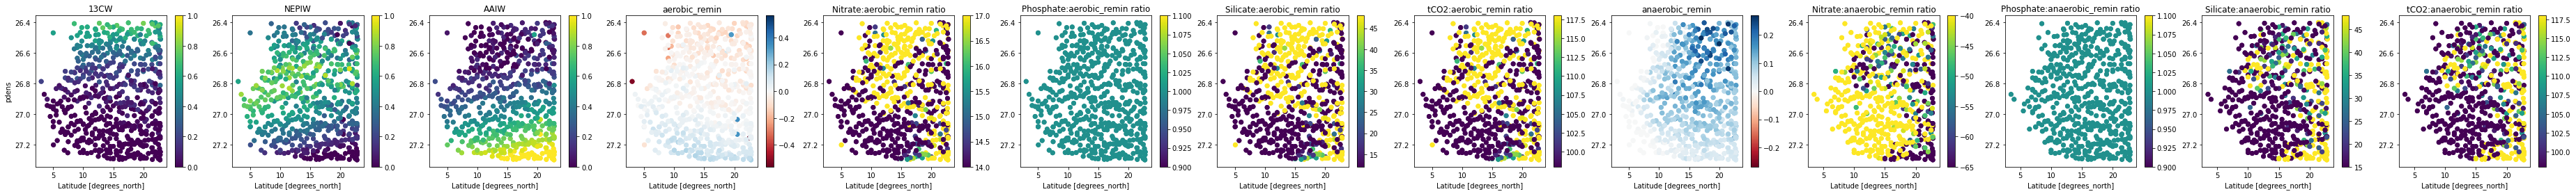

In [ ]:
xaxis_colname="Latitude [degrees_north]"
yaxis_colname = "pdens"
print("Water mass fractions and deltaP")
plot_ompasoln_endmember_fractions(ompa_soln=ETNP_df_ompasoln,
                                  xaxis_colname=xaxis_colname,
                                  yaxis_colname=yaxis_colname)


Plot residuals

Residuals


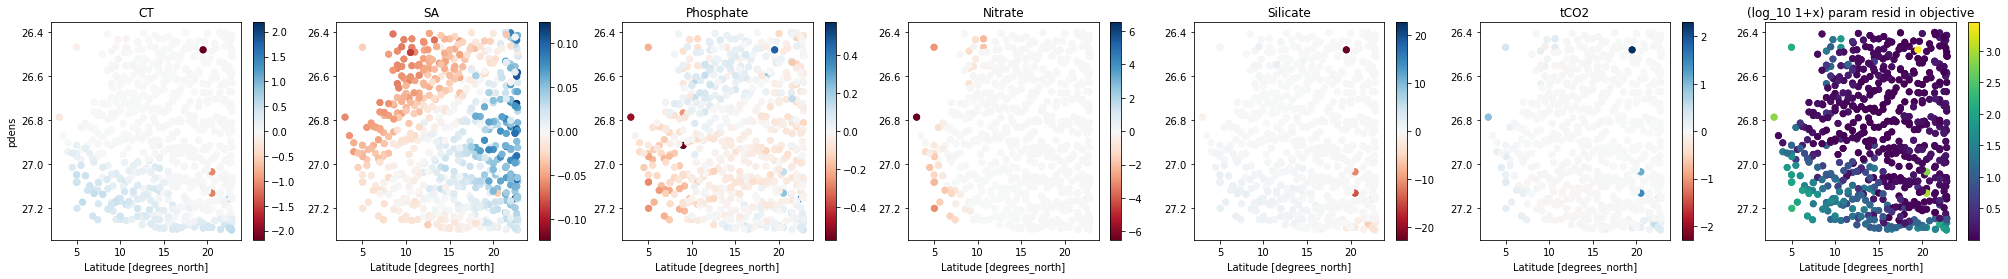

In [ ]:
print("Residuals")
plot_ompasoln_residuals(ompa_soln=ETNP_df_ompasoln,
                        xaxis_colname=xaxis_colname,
                        yaxis_colname=yaxis_colname)

Output the pyompa sol'n




In [ ]:
ORIG_COLS_TO_INCLUDE = list(data_df.columns.values)
ETNP_df_ompasoln.export_to_csv(
    csv_output_name="ETNP_df_ompasoln.csv",
    orig_cols_to_include=ORIG_COLS_TO_INCLUDE)

# This csv is located in the file options to the left on this notebook. There's a little file folder icon. Click on it and the csv should be there and available to download if you click on the three dots next to it

writing to ETNP_df_ompasoln.csv


Starting sensitivity analysis
Don't forget to ask Avanti how to put this file into my github for the paper!

In [ ]:
#Install gp15wmascripts
!pip uninstall -y gp15wma
%cd /content/
!rm -rf gp15wmascripts
!git clone https://github.com/nitrogenlab/gp15wmascripts
%cd /content/gp15wmascripts
!git checkout main
!git log -1
!pip install .
%cd /content/

%reload_ext autoreload
%autoreload 2
from importlib import reload
import gp15wma
reload(gp15wma)

/content
Cloning into 'gp15wmascripts'...
remote: Enumerating objects: 248, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 248 (delta 13), reused 3 (delta 3), pack-reused 226
Receiving objects: 100% (248/248), 16.42 MiB | 26.03 MiB/s, done.
Resolving deltas: 100% (137/137), done.
/content/gp15wmascripts
Already on 'main'
Your branch is up to date with 'origin/main'.
commit 0f8be9e53d4dfdb510bd26abfe98a12fce38a942 (HEAD -> main, origin/main, origin/HEAD)
Author: rml54 <45828236+rml54@users.noreply.github.com>
Date:   Mon Apr 18 17:02:17 2022 -0400

    Update funcdump.py
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/gp15wmascripts
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new beha

<module 'gp15wma' from '/usr/local/lib/python3.7/dist-packages/gp15wma/__init__.py'>

In [ ]:
from gp15wma.sensitivity import BaseSensitivityAnalysis, OmpaArguments

from gp15wma.sensitivity import get_mean_and_stdev_skeletons


In [ ]:
# print("mean")

def plot_ompasoln_residuals2(ompa_soln, xaxis_colname,
                             yaxis_colname, flip_y=True):
  pyompa.plotting.plot_residuals(
          param_residuals=ompa_soln.param_residuals,
          param_names=ompa_soln.param_names,
          xaxis_vals=ompa_soln.obs_df[xaxis_colname],
          xaxis_label=xaxis_colname,
          yaxis_vals=ompa_soln.obs_df[yaxis_colname],
          yaxis_label=yaxis_colname, flip_y=flip_y,
          perobs_weighted_resid_sq=None)


In [ ]:
#Install endmember sensitivities

!wget https://raw.githubusercontent.com/NatalyaEvans/ETNP_stoich/main/pyompa_scripts/endmember_sensitivity_fns.py -O endmember_sensitivity_fns.py

--2022-11-08 05:22:58--  https://raw.githubusercontent.com/NatalyaEvans/ETNP_stoich/main/pyompa_scripts/endmember_sensitivity_fns.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2752 (2.7K) [text/plain]
Saving to: ‘endmember_sensitivity_fns.py’

endmember_sensitivi 100%[===================>]   2.69K  --.-KB/s    in 0s      

2022-11-08 05:22:59 (33.5 MB/s) - ‘endmember_sensitivity_fns.py’ saved [2752/2752]



Sensitivity with regards to endmembers

In [ ]:
from collections import OrderedDict
from endmember_sensitivity_fns import perturb_endmember_df_stoichiometrically

#Prepare the varying OMPA arguments
rng = np.random.RandomState(123) #instantiate random number generator with fixed seed
num_samples = 35
base_endmembers = endmembers_df

#sample varying parameter weightings
sampled_endmembers = []
for i in range(num_samples):
    sampled_endmembers.append(perturb_endmember_df_stoichiometrically(
    endmembers_df,
    # stoichiometry=convertedparamgroups[0].conversion_ratios[1],
    stoichiometry=convertedparamgroups,
    perturbation_limits_0=(-0.075, 0.075),
    scale_factor=1/3,
    rng=rng))
    print("Iteration:", i)
    display(sampled_endmembers[-1])

##write out the various sampled weightings
#open("sampled_endmembers.json", "w").write(
#    json.dumps(sampled_endmembers, indent=4))

varying_arguments_list = [OmpaArguments(
        constructor_arguments={},
        solve_arguments={"endmember_df": df}) for df in sampled_endmembers]

ETNP_weighting_sens_analysis = BaseSensitivityAnalysis(
    static_ompa_arguments = OmpaArguments(
        constructor_arguments={
          "param_weightings": paramweightings,
          "obs_df": ETNP_df_ompasoln.obs_df,
          "endmembername_to_usagepenaltyfunc": usage_penalty,
          "param_names": ETNP_df_ompasoln.param_names,
          "convertedparam_groups": convertedparamgroups
          },
        solve_arguments={
            "endmember_name_column": "Params",
            "batch_size": 100,
            "max_iter": 1000000
        }
    ))

!mkdir endmembers_sensitivity
ompa_solns = ETNP_weighting_sens_analysis.run(
    varying_arguments_list = varying_arguments_list,
    outdir="endmembers_sensitivity",
    export_settings={"orig_cols_to_include":ORIG_COLS_TO_INCLUDE})

Iteration: 0


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.387036  32.600968  25.498418  2249.398064
1  NEPIW   9.47  34.78   2.628894  36.441387  31.378475  2271.727666
2   AAIW   5.53  34.70   3.085183  42.564411  82.710036  2325.776822

Iteration: 1


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.374780  30.268221  25.071474  2242.692484
1  NEPIW   9.47  34.78   2.613130  35.640551  35.825477  2268.528570
2   AAIW   5.53  34.70   3.115817  43.542070  85.073319  2331.556231

Iteration: 2


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.374240  30.358511  26.437047  2251.662930
1  NEPIW   9.47  34.78   2.672087  34.159007  34.785904  2263.664243
2   AAIW   5.53  34.70   3.075348  42.989718  83.585598  2320.127177

Iteration: 3


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.378809  29.889467  26.594253  2251.738091
1  NEPIW   9.47  34.78   2.686352  35.911850  35.090025  2278.527963
2   AAIW   5.53  34.70   3.040367  43.080137  82.877931  2321.701011

Iteration: 4


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.294842  29.859631  26.765503  2244.502746
1  NEPIW   9.47  34.78   2.635488  33.832252  32.823724  2268.162911
2   AAIW   5.53  34.70   3.099460  42.656304  83.373898  2326.909599

Iteration: 5


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.416802  30.913564  25.190645  2245.103359
1  NEPIW   9.47  34.78   2.626241  35.143068  35.393537  2273.082725
2   AAIW   5.53  34.70   3.123055  44.813396  85.390502  2316.784513

Iteration: 6


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.326041  30.931322  26.047942  2249.763556
1  NEPIW   9.47  34.78   2.698464  35.819509  35.508043  2262.395606
2   AAIW   5.53  34.70   3.183241  43.733793  84.980927  2326.648185

Iteration: 7


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.371565  33.102111  26.170823  2239.464055
1  NEPIW   9.47  34.78   2.679079  35.000698  32.109676  2269.248719
2   AAIW   5.53  34.70   3.183822  42.436333  82.821300  2331.173192

Iteration: 8


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.343643  32.274240  26.927027  2253.291459
1  NEPIW   9.47  34.78   2.651867  34.317996  34.445823  2269.825683
2   AAIW   5.53  34.70   3.071637  42.006902  81.181687  2321.696599

Iteration: 9


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.291590  31.660442  23.924469  2255.993792
1  NEPIW   9.47  34.78   2.619062  36.664547  31.410772  2262.813537
2   AAIW   5.53  34.70   3.206282  44.176956  83.002356  2320.473609

Iteration: 10


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.274591  31.492014  27.106509  2236.973149
1  NEPIW   9.47  34.78   2.627588  35.998104  33.694771  2268.886254
2   AAIW   5.53  34.70   3.201345  44.053655  82.865131  2321.610449

Iteration: 11


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.322768  31.043858  25.092209  2242.096113
1  NEPIW   9.47  34.78   2.597132  35.190843  33.539646  2277.033681
2   AAIW   5.53  34.70   3.077539  42.948526  83.512114  2317.650591

Iteration: 12


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.405168  29.475014  22.569861  2243.307438
1  NEPIW   9.47  34.78   2.711574  37.610270  34.422990  2271.036943
2   AAIW   5.53  34.70   3.140960  43.730287  82.055640  2324.972412

Iteration: 13


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.346354  31.380447  23.946926  2251.615176
1  NEPIW   9.47  34.78   2.642169  34.479236  32.694918  2275.660398
2   AAIW   5.53  34.70   3.145376  42.847502  83.767519  2323.929629

Iteration: 14


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.325592  31.619902  27.843711  2238.599660
1  NEPIW   9.47  34.78   2.710103  36.342642  35.188373  2267.332898
2   AAIW   5.53  34.70   3.130794  43.138046  84.221732  2316.519885

Iteration: 15


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.350461  30.829681  23.725221  2253.982184
1  NEPIW   9.47  34.78   2.592602  34.134148  35.475044  2266.599349
2   AAIW   5.53  34.70   3.168624  43.098077  84.874733  2321.761341

Iteration: 16


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.398704  30.263848  24.642497  2251.547302
1  NEPIW   9.47  34.78   2.614397  35.847085  33.436526  2268.110913
2   AAIW   5.53  34.70   3.100905  44.609538  82.064348  2329.550378

Iteration: 17


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.338271  31.774335  25.939954  2254.385615
1  NEPIW   9.47  34.78   2.602804  36.223076  32.667241  2267.209974
2   AAIW   5.53  34.70   3.066985  41.572953  86.449687  2323.272279

Iteration: 18


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.303786  31.827131  22.891213  2241.286788
1  NEPIW   9.47  34.78   2.638413  34.497620  35.778429  2277.860234
2   AAIW   5.53  34.70   3.094940  43.608427  84.704475  2320.170010

Iteration: 19


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.303202  32.000578  24.217546  2252.591456
1  NEPIW   9.47  34.78   2.576989  35.713709  34.130062  2263.963117
2   AAIW   5.53  34.70   3.155163  44.522897  82.153968  2323.904811

Iteration: 20


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.302380  32.054603  27.968445  2245.049600
1  NEPIW   9.47  34.78   2.649863  34.810544  33.212480  2275.861130
2   AAIW   5.53  34.70   3.154606  42.650380  82.091038  2316.336976

Iteration: 21


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.404362  32.422987  25.100959  2254.020488
1  NEPIW   9.47  34.78   2.670319  36.852037  35.992359  2261.599094
2   AAIW   5.53  34.70   3.119796  43.942470  83.069003  2317.308558

Iteration: 22


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.421018  31.407598  24.605274  2251.026659
1  NEPIW   9.47  34.78   2.659234  34.721124  33.751189  2262.885873
2   AAIW   5.53  34.70   3.038040  41.913733  84.318414  2322.002433

Iteration: 23


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.372411  32.148699  26.529642  2248.574230
1  NEPIW   9.47  34.78   2.671916  34.332930  34.418810  2266.696678
2   AAIW   5.53  34.70   3.073220  43.482061  81.575012  2321.583313

Iteration: 24


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.400040  31.175678  26.614534  2247.683357
1  NEPIW   9.47  34.78   2.713661  37.049769  32.550220  2266.577955
2   AAIW   5.53  34.70   3.198137  43.673057  82.927563  2323.119320

Iteration: 25


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.404039  32.140251  24.741080  2254.977274
1  NEPIW   9.47  34.78   2.679540  34.518716  35.646227  2264.740290
2   AAIW   5.53  34.70   3.205286  43.731695  82.268356  2333.125303

Iteration: 26


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.419460  29.930705  24.184249  2252.723289
1  NEPIW   9.47  34.78   2.625046  35.151641  35.458515  2273.592414
2   AAIW   5.53  34.70   3.137421  42.387686  85.092464  2317.202745

Iteration: 27


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.328947  31.509233  24.025849  2250.983363
1  NEPIW   9.47  34.78   2.610615  34.125868  36.176572  2269.248148
2   AAIW   5.53  34.70   3.118764  41.714315  83.191204  2320.615412

Iteration: 28


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.416276  32.940608  24.250640  2244.778503
1  NEPIW   9.47  34.78   2.664991  35.511112  35.221793  2269.614904
2   AAIW   5.53  34.70   3.098369  44.097000  85.040812  2322.381710

Iteration: 29


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.446742  32.872536  25.600890  2254.452967
1  NEPIW   9.47  34.78   2.630237  33.859750  32.816718  2270.318914
2   AAIW   5.53  34.70   3.136255  42.793154  83.590260  2313.053453

Iteration: 30


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.342819  31.851049  24.859987  2243.620102
1  NEPIW   9.47  34.78   2.705149  36.645310  33.523158  2270.394018
2   AAIW   5.53  34.70   3.194495  42.185372  83.508933  2327.881608

Iteration: 31


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.415762  30.196338  24.189028  2248.123468
1  NEPIW   9.47  34.78   2.676330  35.794674  34.990271  2275.945648
2   AAIW   5.53  34.70   3.202389  42.030722  84.263378  2329.320902

Iteration: 32


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.297055  32.939903  26.492576  2253.818411
1  NEPIW   9.47  34.78   2.658803  33.974378  33.654724  2274.156566
2   AAIW   5.53  34.70   3.213062  41.783573  82.606752  2315.879491

Iteration: 33


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.362735  30.800166  28.070766  2252.596760
1  NEPIW   9.47  34.78   2.650155  36.434805  33.903414  2266.579737
2   AAIW   5.53  34.70   3.096088  42.035155  82.941102  2318.046169

Iteration: 34


Params     CT     SA  Phosphate    Nitrate   Silicate         tCO2
0   13CW  13.41  34.95   2.306473  31.577420  25.719275  2247.741988
1  NEPIW   9.47  34.78   2.598264  37.808445  35.746834  2268.429346
2   AAIW   5.53  34.70   3.164095  42.083961  82.593919  2318.583904

Streaming output truncated to the last 5000 lines.
Original weighted sum squares: 2505.1668528925593
Post fix weighted sum squared: 2505.1668534702494
On example 600 to 700 out of 1220
status: optimal
optimal value 2117.2652956585357
Original weighted sum squares: 2117.2649601868643
Post fix weighted sum squared: 2117.2649612321375
On example 700 to 800 out of 1220
status: optimal
optimal value 4077.8652711864424
Original weighted sum squares: 4077.86363122737
Post fix weighted sum squared: 4077.8636375668457
On example 800 to 900 out of 1220
status: optimal
optimal value 8431.642840479817
Original weighted sum squares: 8431.56144463544
Post fix weighted sum squared: 8431.561444725843
On example 900 to 1000 out of 1220
status: optimal
optimal value 1309.3129543722678
Original weighted sum squares: 1309.3128378732831
Post fix weighted sum squared: 1309.3128379861569
On example 1000 to 1100 out of 1220
status: optimal
optimal value 1102.0283172180118
Original weighted sum squares: 1102.0

mean


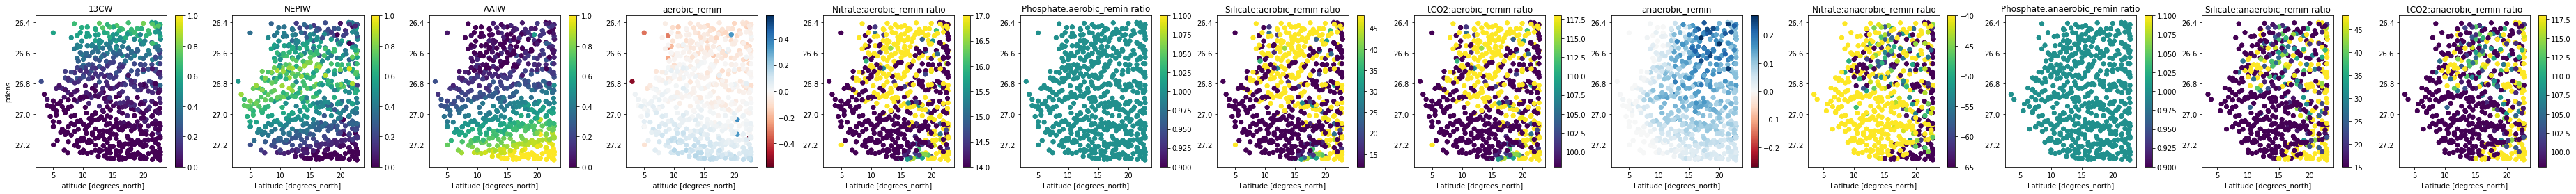

std


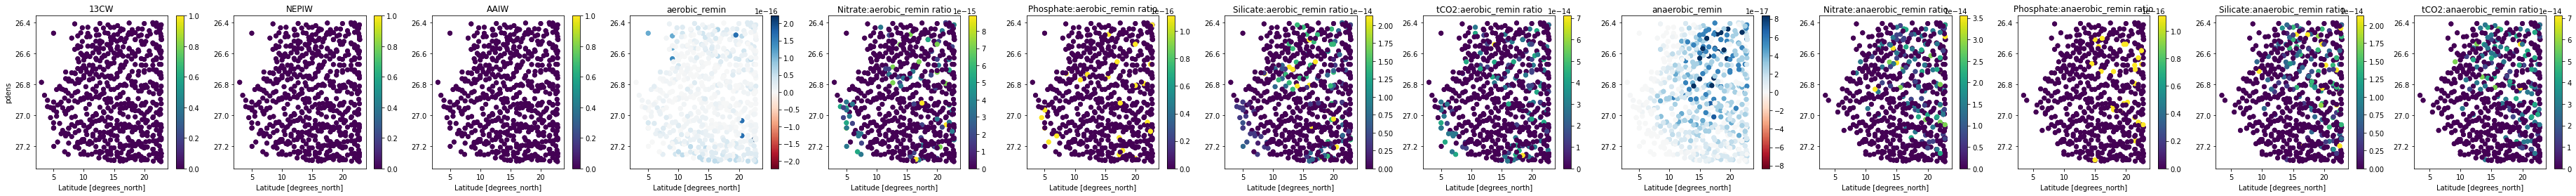

In [ ]:
#plot the solutions

mean_skeleton_endmembers, std_skeleton_endmembers = get_mean_and_stdev_skeletons(ompa_solns=ompa_solns)

print("mean")
pyompa.plot_ompasoln_endmember_fractions(ompa_soln=mean_skeleton_endmembers,
                                  xaxis_colname="Latitude [degrees_north]",
                                  yaxis_colname="pdens")
print("std")
pyompa.plot_ompasoln_endmember_fractions(ompa_soln=std_skeleton_endmembers,
                                  xaxis_colname="Latitude [degrees_north]",
                                  yaxis_colname="pdens")

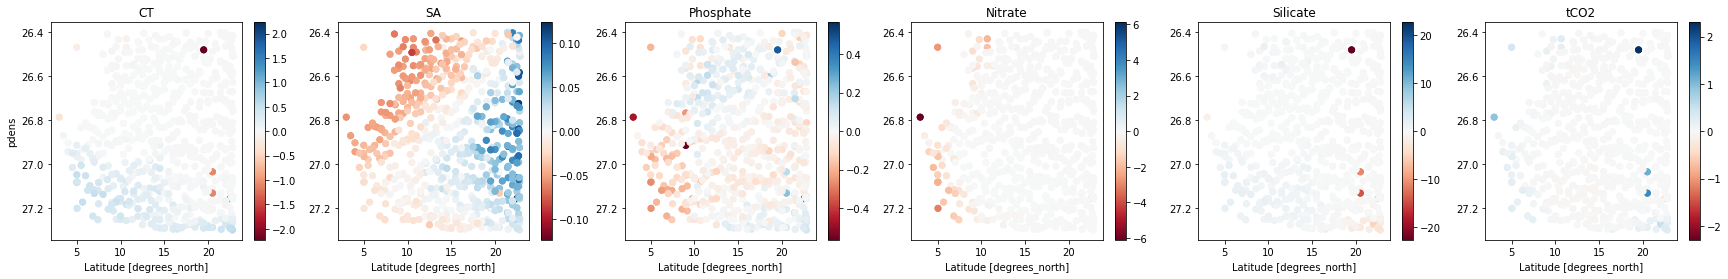

std


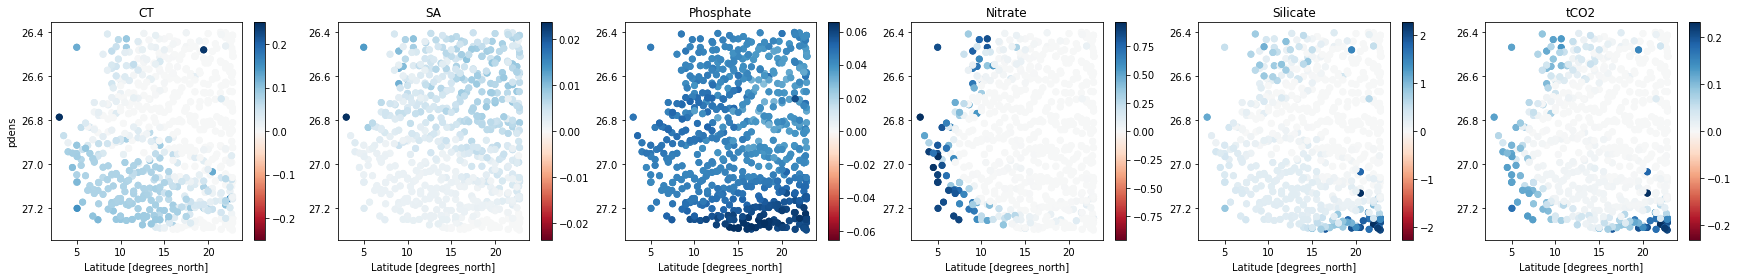

In [ ]:
plot_ompasoln_residuals2(ompa_soln=mean_skeleton_endmembers,
                                  xaxis_colname="Latitude [degrees_north]",
                                  yaxis_colname="pdens")
print("std")
plot_ompasoln_residuals2(ompa_soln=std_skeleton_endmembers,
                                  xaxis_colname="Latitude [degrees_north]",
                                  yaxis_colname="pdens")

Sensitivity with regards to weightings

In [ ]:
#Prepare the varying OMPA arguments

rng = np.random.RandomState(1234) #instantiate random number generator with fixed seed
num_samples = 20
base_weighting = paramweightings

#sample varying parameter weightings
sampled_weightings = []
for i in range(num_samples):
    rand_weighting = dict([
        (key, rng.uniform(value*0.8, value*1.2))
        for key,value in base_weighting.items()
    ])
    sampled_weightings.append(rand_weighting)

#write out the various sampled weightings
open("sampled_weightings.json", "w").write(
    json.dumps(sampled_weightings, indent=4))

varying_arguments_list = [OmpaArguments(
        constructor_arguments={"param_weightings": rand_weighting},
        solve_arguments={}) for weighting in sampled_weightings]

ETNP_weighting_sens_analysis = BaseSensitivityAnalysis(
    static_ompa_arguments = OmpaArguments(
        constructor_arguments={
          "obs_df": ETNP_df_ompasoln.obs_df,
          "endmembername_to_usagepenaltyfunc": usage_penalty,
          "param_names": ETNP_df_ompasoln.param_names,
          "convertedparam_groups": convertedparamgroups
          },
        solve_arguments={
            "endmember_df": endmembers_df,
            "endmember_name_column": "Params",
            "batch_size": 100
        }
    ))

!mkdir param_weightings_sensitivity
ompa_solns = ETNP_weighting_sens_analysis.run(
    varying_arguments_list = varying_arguments_list,
    outdir="param_weightings_sensitivity",
    export_settings={"orig_cols_to_include":ORIG_COLS_TO_INCLUDE})


On varying argument 0 out of 20
varying arguments: OMPAArguments(constructor_arguments={'param_weightings': {'CT': 13.819531975270444, 'SA': 7.208370416148897, 'Phosphate': 5.635221102886431, 'Nitrate': 3.492141970528494, 'tCO2': 4.642873682193587, 'Silicate': 2.165222530537438}}, solve_arguments={})
Adding penalty for AAIW
Endmember-idx mapping is
 OrderedDict([('13CW', [0]), ('NEPIW', [1]), ('AAIW', [2])])
params to use: ['CT', 'SA', 'Phosphate', 'Nitrate', 'Silicate', 'tCO2']
param weighting: [13.81953198  7.20837042  5.6352211   3.49214197  2.16522253  4.64287368]
Matrix A:
Trying convertedvariable sign constraint: [1 1 1 1]
On example 0 to 100 out of 1220
status: optimal
optimal value 84820.97901673203
Original weighted sum squares: 84820.97901673203
Post fix weighted sum squared: 84825.61055084896
On example 100 to 200 out of 1220
status: optimal
optimal value 3224.1360927064684
Original weighted sum squares: 3224.136091522564
Post fix weighted sum squared: 3224.1361334540134
On 

mean


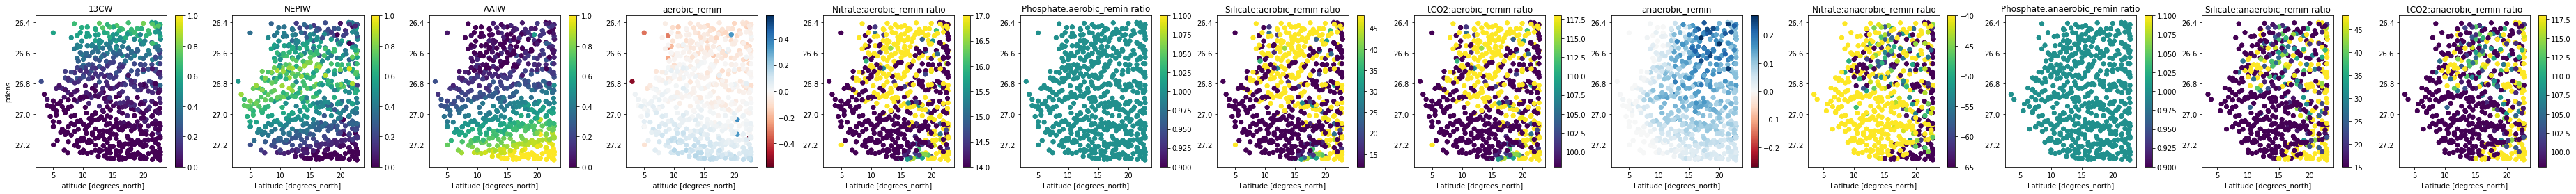

std


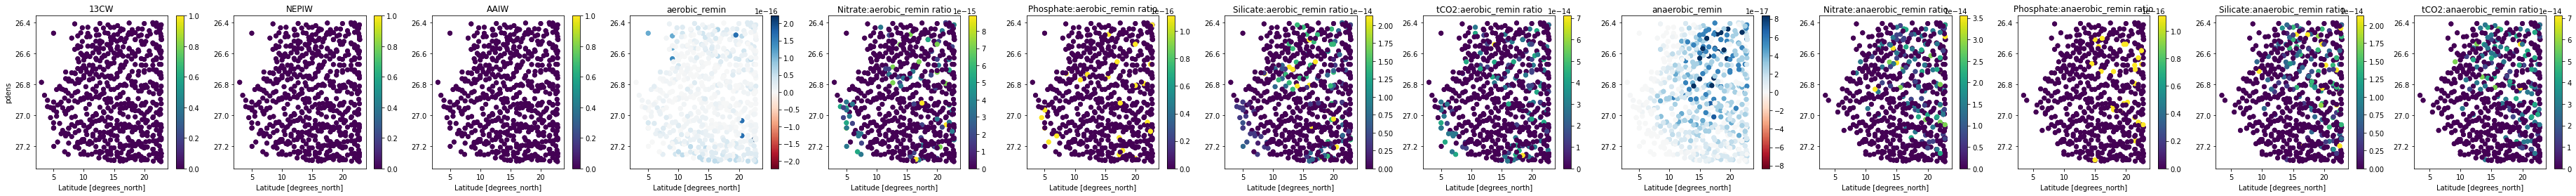

In [ ]:
#plot the solutions

mean_skeleton_weightings, std_skeleton_weightings = get_mean_and_stdev_skeletons(ompa_solns=ompa_solns)

print("mean")
pyompa.plot_ompasoln_endmember_fractions(ompa_soln=mean_skeleton_weightings,
                                  xaxis_colname="Latitude [degrees_north]",
                                  yaxis_colname="pdens")
print("std")
pyompa.plot_ompasoln_endmember_fractions(ompa_soln=std_skeleton_weightings,
                                  xaxis_colname="Latitude [degrees_north]",
                                  yaxis_colname="pdens")

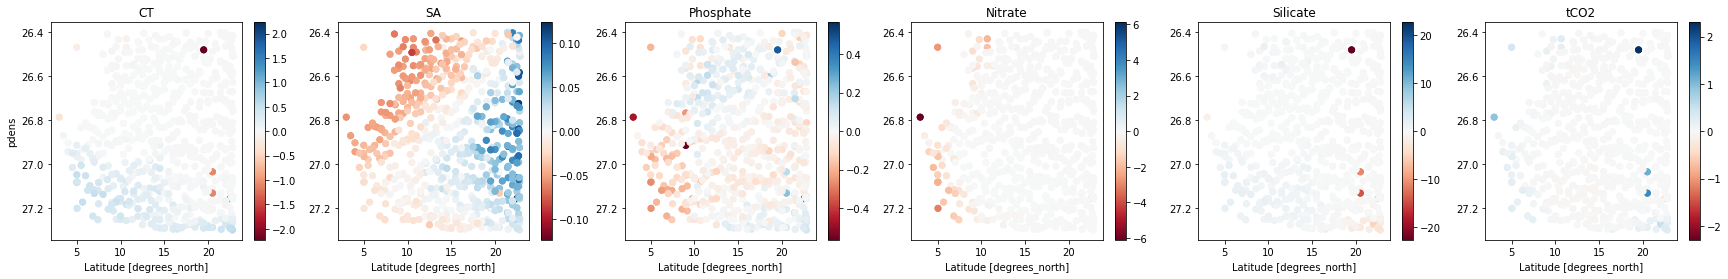

std


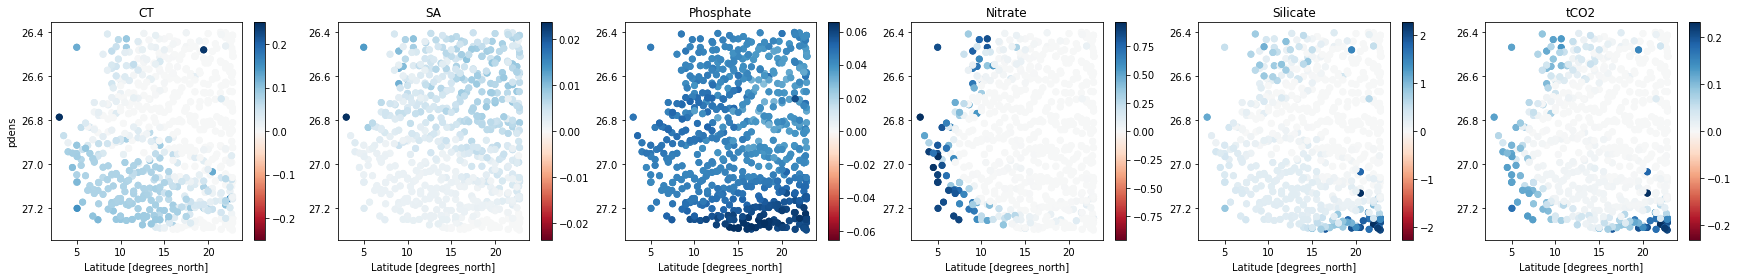

In [ ]:
plot_ompasoln_residuals2(ompa_soln=mean_skeleton_endmembers,
                                  xaxis_colname="Latitude [degrees_north]",
                                  yaxis_colname="pdens")
print("std")
plot_ompasoln_residuals2(ompa_soln=std_skeleton_endmembers,
                                  xaxis_colname="Latitude [degrees_north]",
                                  yaxis_colname="pdens")

In [ ]:
ORIG_COLS_TO_INCLUDE = ORIG_COLS_TO_INCLUDE
mean_skeleton_endmembers.export_to_csv(
    csv_output_name="mean_skeleton_endmembers.csv",
    orig_cols_to_include=ORIG_COLS_TO_INCLUDE)
std_skeleton_endmembers.export_to_csv(
    csv_output_name="std_skeleton_endmembers.csv",
    orig_cols_to_include=ORIG_COLS_TO_INCLUDE)

mean_skeleton_weightings.export_to_csv(
    csv_output_name="mean_skeleton_weightings.csv",
    orig_cols_to_include=ORIG_COLS_TO_INCLUDE)
std_skeleton_weightings.export_to_csv(
    csv_output_name="std_skeleton_weightings.csv",
    orig_cols_to_include=ORIG_COLS_TO_INCLUDE)

# This csv is located in the file options to the left on this notebook. There's a little file folder icon. Click on it and the csv should be there and available to download if you click on the three dots next to it

writing to mean_skeleton_endmembers.csv
writing to std_skeleton_endmembers.csv
writing to mean_skeleton_weightings.csv
writing to std_skeleton_weightings.csv
